# Time Series Forecasting

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") # Ignorar warnings de convergencia de ARIMA para simplificar

## 1. Generar datos sintéticos (tendencia + estacionalidad + ruido)

In [4]:
np.random.seed(0)
n_points = 120
time = np.arange(n_points)
# Tendencia lineal + Estacionalidad (sinusoidal) + Ruido
trend = 0.3 * time
seasonality = 10 * np.sin(2 * np.pi * time / 12) # Ciclo anual (12 meses)
noise = np.random.normal(scale=3, size=n_points)
data = trend + seasonality + noise + 50 # Añadir un offset

# Crear un Pandas Series con índice de tiempo (simulando meses)
# Es importante usar un DatetimeIndex para muchas funciones de statsmodels
index = pd.date_range(start='2015-01-01', periods=n_points, freq='MS') # 'MS' para inicio de mes
ts = pd.Series(data, index=index)

print("Serie Temporal Sintética con Estacionalidad (primeros 12 puntos):")
print(ts.head(12))
print("\n")

Serie Temporal Sintética con Estacionalidad (primeros 12 puntos):
2015-01-01    55.292157
2015-02-01    56.500472
2015-03-01    62.196468
2015-04-01    67.622680
2015-05-01    65.462928
2015-06-01    53.568166
2015-07-01    54.650265
2015-08-01    46.645928
2015-09-01    43.430089
2015-10-01    43.931796
2015-11-01    44.771877
2015-12-01    52.662821
Freq: MS, dtype: float64




## 2. Separar en Train/Test

In [5]:

train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]

print(f"Tamaño del Train set: {len(train)}")
print(f"Tamaño del Test set: {len(test)}")
print("\n")

Tamaño del Train set: 96
Tamaño del Test set: 24





## 3. Ajustar un modelo ARIMA

In [6]:
# Parámetros (p, d, q) - Estos a menudo se eligen mediante análisis ACF/PACF y tests de estacionariedad
# p: Orden AR (Autoregresivo)
# d: Orden de diferenciación (para estacionariedad)
# q: Orden MA (Media Móvil)
# Para este ejemplo, elegimos valores razonables. (d=1 por la tendencia, p=5 por dependencias, q=0)
order = (5, 1, 0)
model = ARIMA(train, order=order)
model_fit = model.fit()

print(model_fit.summary()) # Muestra un resumen del modelo ajustado
print("\n")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -280.795
Date:                Wed, 02 Apr 2025   AIC                            573.590
Time:                        20:58:34   BIC                            588.913
Sample:                    01-01-2015   HQIC                           579.781
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0737      0.101     -0.730      0.465      -0.272       0.124
ar.L2          0.3451      0.096      3.582      0.000       0.156       0.534
ar.L3          0.1020      0.095      1.070      0.2

## 4. Realizar predicciones sobre el conjunto de test

In [7]:

# 'start' y 'end' se refieren a los índices del DataFrame original
start_index = test.index[0]
end_index = test.index[-1]
predictions = model_fit.predict(start=start_index, end=end_index)



Alternativamente, para predecir N pasos hacia adelante desde el final del train set:
- n_forecast_steps = len(test)
- predictions = model_fit.get_forecast(steps=n_forecast_steps).predicted_mean

## 5. Evaluar el modelo

In [8]:

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f"--- Modelo: ARIMA{order} ---")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

--- Modelo: ARIMA(5, 1, 0) ---
Test MSE: 88.6990
Test RMSE: 9.4180


## 6. Visualizar los resultados

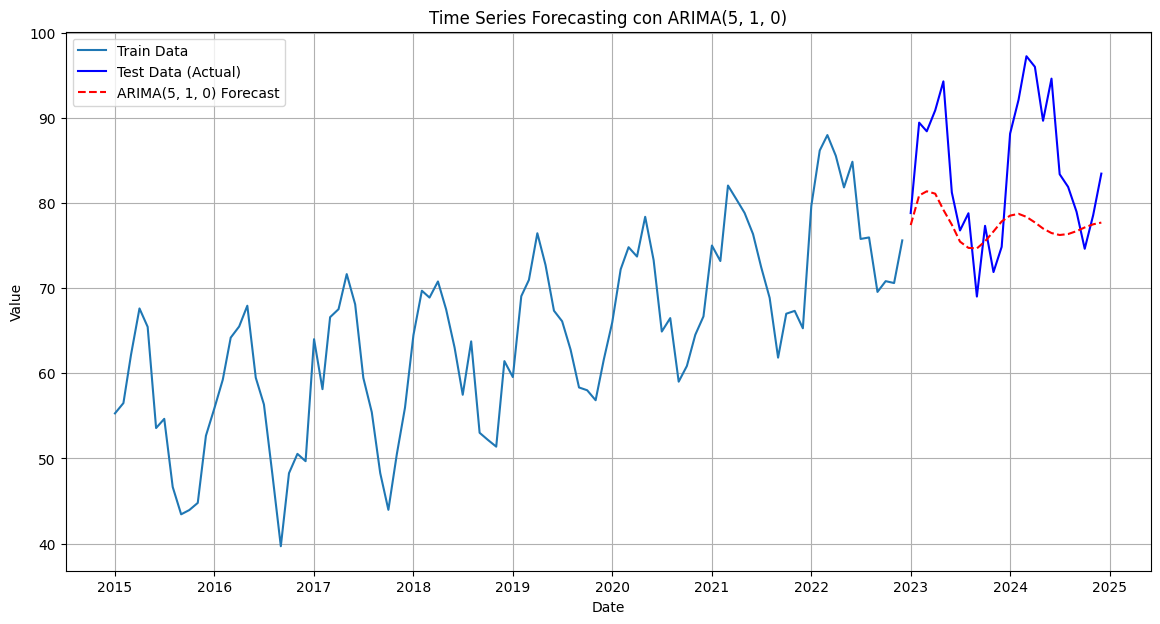

In [9]:

plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data (Actual)', color='blue')
plt.plot(predictions.index, predictions, label=f'ARIMA{order} Forecast', color='red', linestyle='--')
plt.title(f'Time Series Forecasting con ARIMA{order}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

(Opcional) Visualizar Diagnósticos del Modelo (residuos)   
Un buen modelo debería tener residuos que se asemejen a ruido blanco
(media cero, varianza constante, sin autocorrelación)
```
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()
```